In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
import astropy.units as u
font = {'size'   : 22}

matplotlib.rc('font', **font)
from lightcurve import get_lightcurve

Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114
Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


In [2]:
def create_and_plot_lc(*args, **kwargs):
    lightcurve = get_lightcurve(*args, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'].value > 1) | (lightcurve['snr_D2'].value > 1)
    lightcurve = lightcurve[good]
    ax0.errorbar(lightcurve['Time'].value / 86400, lightcurve['ABmag_D1'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['ABmag_D1_err'].value)
    ax0.errorbar(lightcurve['Time'].value / 86400, lightcurve['ABmag_D2'].value, 
                 fmt='o', markersize=2, yerr=lightcurve['ABmag_D2_err'].value)
    ax1.scatter(lightcurve['Time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['Time'].value / 86400, lightcurve['snr_D2'].value, s=2)

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
    ymin = min(lightcurve['ABmag_D1'].value.min(), lightcurve['ABmag_D2'].value.min()) - 1
    ymax = max(lightcurve['ABmag_D1'].value.max(), lightcurve['ABmag_D2'].value.max()) + 1
    # Inverted ax for magnitude
    ax0.set_ylim([ymax, ymin])
#    ax1.semilogx();
    

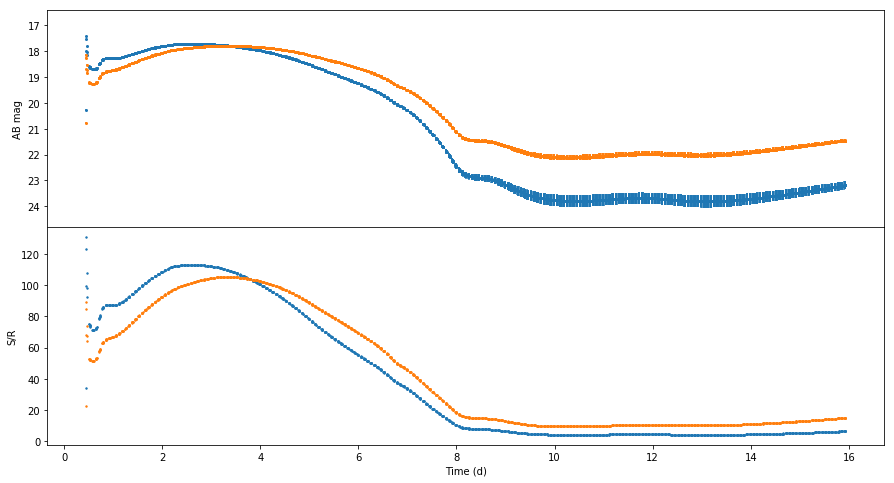

In [3]:
create_and_plot_lc("input_data/SNIIb_lightcurve_DUET.fits", distance=100e6*u.pc)

Now specifying the observing window...

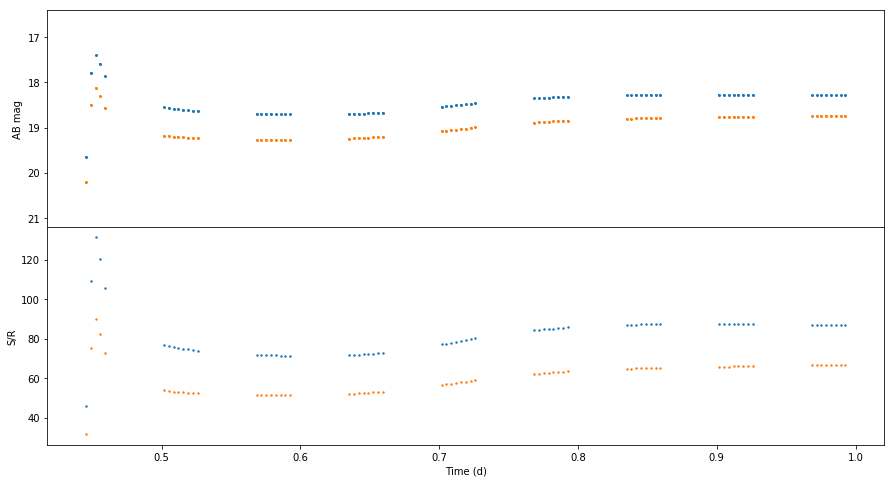

In [4]:
create_and_plot_lc("input_data/SNIIb_lightcurve_DUET.fits", distance=100e6*u.pc,
                  observing_windows=np.array([[0, 90000]])*u.s, phase_start=0.5, exposure_per_orbit=40*60.)